In [1]:
from pathlib import Path
import torch
from torch import nn, optim
from mltools import ld, models, MachineLearning

In [2]:
train_iter, val_iter, test_iter, vocab = ld.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv')
embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=256, padding_idx=1)
encode_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, batch_first=True)
hidden_layer = nn.TransformerEncoder(encode_layer, num_layers=6)  # 定义TransformerEncoder
model = models.TransformerEncodeCModel(embedding, hidden_layer, input_size=256, output_size=2)
device = torch.device('cuda')


class TransformerCSCMachineLearning(MachineLearning):
    def grad_update(self, loss):
        '''梯度更新'''
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
        self.optimizer.step()

    def show_pred(self, contents, preds, reals):
        for content, pred, real in zip(contents, preds, reals):
            print(f'pred: {pred}, real: {real}, text: {''.join(vocab[content.tolist()]).replace('<pad>', ' ')}')


ml = TransformerCSCMachineLearning(model, train_iter, val_iter, test_iter, device=device)
model_path = '../model/Transformer_CSC.pth'

train loss 2.295, val loss 1.034, val acc 0.308
66.6 sec/epoch on cuda


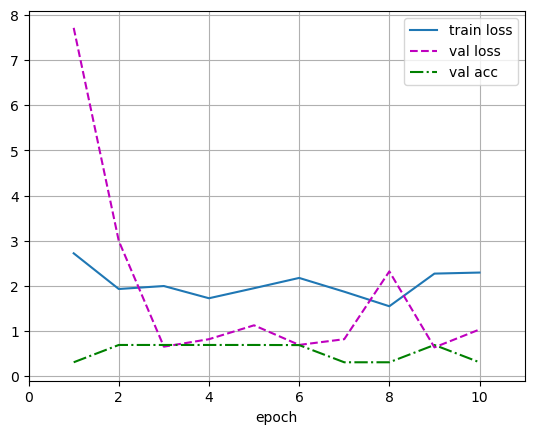

In [ ]:
ml.set_loss(nn.CrossEntropyLoss())
ml.set_optimizer(optim.SGD(model.parameters(), lr=1))
if True:
    ml.train(num_epochs=10)  # 训练
    if False:
        torch.save(model.state_dict(), model_path)
elif Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))

In [4]:
ml.test()  # 测试

Accuracy rate 0.313893653516295


In [5]:
ml.predict()  # 预测

pred: 0, real: 0, text: 也许黄金海岸有自己的酒店评级机构,给此中心评了个"四星",不然不好意思收四五百的房租啊!也就二星的标准,大堂里蚊子那叫一个多...卫生间和浴室的门都关不上,的用手<unk>着!电话不响,得用自己的手机.毛巾不知是哪年的了，估计本世纪初的产品。装修用的是最低档的地砖和大理石...另外，当地民风极差，无论你在酒店里，海滩上，外面餐馆，只要你出手消费，必定挨宰！下次宁愿远<unk>青岛威海，也不来黄金海岸，南戴河了。海
pred: 0, real: 1, text: 房间小,感觉卫生不太好,整个环境显的很陈旧.服务一般.                                                                                                                                                                             
pred: 0, real: 1, text: 我们定的是特价大床房，很幸运，去了就免费升级成豪华大床房了。位于四楼，房间还算宽敞，而且很干净。我喜欢洗手间的玻璃屏风，这样显得整个房间比较大。不喜欢透明的话还可以放下卷帘。这儿的床很好。床旁边的台灯也漂亮。唯一毛病是淋浴房门无法合紧，洗澡的时候要<unk>着门，防止水溅出。好在只住一晚，这点小困难还可以克服。总的来讲，三百元就住到这样的旅馆，性价比已经非常好了。                     
pred: 0, real: 0, text: 388元的房间,也就值248元.上网居然收费且人工配制IP.打死也不再住.                                                                                                                                                                   
pred: 0, real: 0, text: 凌晨近二点到店，就我一个客人在前台办手续，办了十分钟才办好，更郁闷的是酒店竟然开了一个没有打扫过的房间给我，房号463，住了这么